In [ ]:
# Python Script
# Calibration of the diffraction projection
# from a diffraction pattern of a known crystal
#
# by J. Barthel / Forschungszentrum Jülich GmbH, Jülich, Germany
# email: ju.barthel@fz-juelich.de
#
# 2019 July 3
#
# Part of the emilys project: https://github.com/ju-bar/emilys
# published under the GNU GPL 3.0 License
#
# - record a diffraction pattern with as parallel illumination as possible
# - avoid recording noisy data (make long exposures)
# - avoid over saturation of the detector
# - avoid strong diffraction defocus or astigmatism
#
# Some of the procedure steps are commented extensively, indicating
# steps with fudge parameters. Tuning these parameters may help to
# improve the quality of the result. It is recommended to note changes
# and keep the original values in comments.
#

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Arrow
from scipy.optimize import curve_fit, minimize
import emilys.image.arrayplot as aplt
from emilys.numerics.mc import mc_image_pos_maximize
from emilys.image.imagedata import image_pos_sum
import emilys.numerics.cluster as clus
from emilys.optics.projection import projection_func_2d as proj2d
%matplotlib inline
# development imports on autoreload
#%load_ext autoreload
#%autoreload 1
#%aimport emilys.optics.projection

In [2]:
sworkdir = '../data/' # ! Set working directory !
ldat0 = np.fromfile(sworkdir + 'dif_cal_avg.dat', dtype='float64') # load the image data

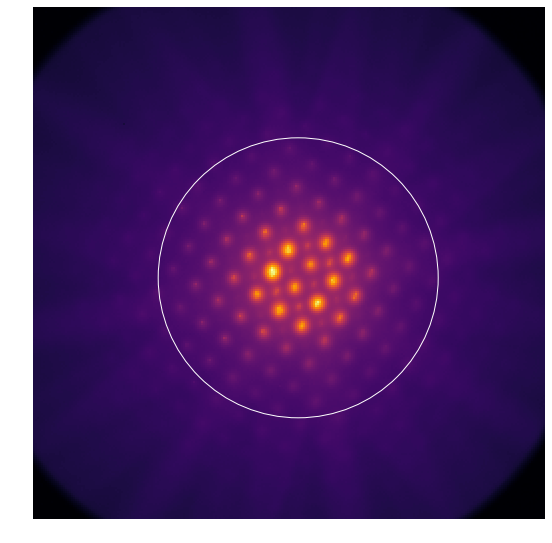

In [3]:
ndim = np.array([256,256]) # ! Set image dimension !
pcenter = np.array([132.,120.]) # ! Set center of peak search area !
prange = 70. # ! Set range of peak search area !
limg0 = ldat0.reshape(ndim) # get the image in shape
%matplotlib inline
fig0, ax0 = aplt.arrayplot2d(limg0**0.3,2,'inferno') # plot image and enhance low at low intensities
prangecircle = Circle(pcenter, prange, color='w', fill=False)
ax0.add_patch(prangecircle)

In [4]:
# Locating local minima using a Monte-Carlo approach
# This cell does some initializations. The Monte-Carlo is done with the cell below.
# - determine the intensity variations for pixels close to the range circle defined above
sr1 = 0.
sr2 = 0.
srn = 0
si = 0.
for j in range(0,ndim[0]):
    for i in range(0,ndim[1]):
        if np.abs(np.sqrt((i-pcenter[0])**2 + (j-pcenter[1])**2) - prange) < 1.:
            si = limg0[j,i]
            sr1 += si
            sr2 += si**2
            srn += 1
rmean = sr1 / srn
rsdev = np.sqrt(sr2 / srn - rmean*rmean)
print('- intensity on range limit (mean, sdev):',[rmean,rsdev])
# - initialize a list of points (one for each second second pixel in the range)
lrpt = np.array([])
nrpt = 0
for j in range(0,ndim[0],2):
    for i in range(0,ndim[1],2):
        if np.sqrt((i - pcenter[0])**2 + (j - pcenter[1])**2) < prange:
            if nrpt == 0:
                lrpt = np.array([[1.*i,1.*j]])
            else:
                lrpt = np.concatenate((lrpt,np.array([[1.*i,1.*j]])))
            nrpt += 1
print('- test points for peak finding:', lrpt.shape[0])

- intensity on range limit (mean, sdev): [1.2812710840373993, 0.20246023620516143]
- test points for peak finding: 3841


In [8]:
# This cell will let the test points in lrpt 'walk' towards local maxima
# - repeat until iterations < itmax or improvement is small (<1%)
# - decrease 'pstep' and 'tempr' to improve / converge
itmax = 100 # number of iterations (100 is OK)
tempr = rsdev/100 # temperture (lower or about the rms noise estimate)
pstep = 1. # rms walking step size (1 pixel is OK)
s0 = image_pos_sum(limg0, lrpt)
nit = mc_image_pos_maximize(limg0, lrpt, pstep, tempr, itmax)
s1 = image_pos_sum(limg0, lrpt)
print('- initial: {:8.3e}, final: {:8.3e}, change: {:6.2f}% , iter: {:d}'.format(s0,s1,100.*(s1/s0 - 1.),nit))

- initial: 1.023e+05, final: 1.028e+05, change:   0.51% , iter: 100


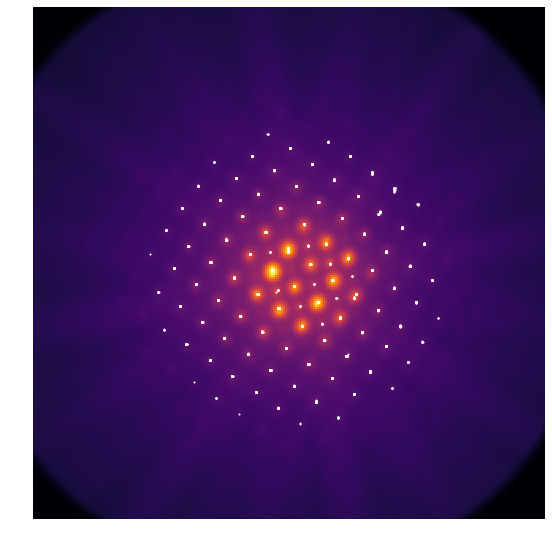

In [9]:
# Plot the image and overlay the test points.
# This may help to decide when to stop iterating the cell above.
fig1, ax1 = aplt.arrayplot2d(limg0**0.3,2,'inferno') # plot image
# add test points
ax1.scatter(*lrpt.T,s=1.,c='w')

In [10]:
# Run a primitive cluster recognition on the point distribution lrpt
clrad0 = 4. # ! Set cluster radius threshold in pixels ! (choose to separate peaks)
ierr = 0
lcl = clus.cluster_l2(lrpt, clrad0)
print('- number of clusters:', len(lcl.lcluster)) 

-  3841 of 3841  items assigned to  104  clusters
- number of clusters: 104


- reducing to clusters with more than  7  votes ...
- 94  peaks suggested.
- smallest distance [pix]: 8.137475715919418


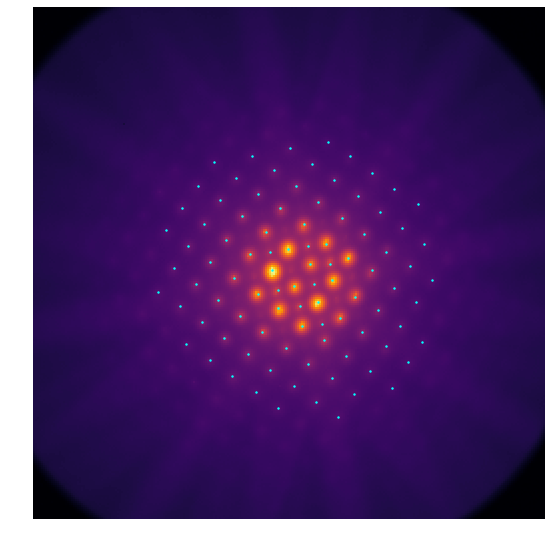

In [11]:
# Remove small clusters
# - Define the cluster population threshold!
#   We expect a uniform distribution of maxima in the search range.
#   Given the number of points N and the number of clusters M, a good
#   cluster should be populated by about N/M points. Clusters with
#   populations 'well below' this expectation may be false positives.
#   The relative threshold 'rpopthr' in the range 0 ... 1 expresses
#   what we mean by 'well below'. Take care not to exclude too many
#   good clusters by checking the outcome with the plot in the cell below.
rpopthr = 0.2 # ! Set this to identify low population thresholds ! (0 ... 1, 0.1 is OK)
nclpop = int(lrpt.shape[0] / len(lcl.lcluster) * rpopthr)
print('- reducing to clusters with more than ', nclpop,' votes ...')
lpk0 = []
for l in range(0, len(lcl.lcluster)):
    if len(lcl.lcluster[l].population) > nclpop:
        lpk0.append(lcl.lcluster[l].mean)
print('-',len(lpk0),' peaks suggested.')
fig2, ax2 = aplt.arrayplot2d(limg0**0.3, 2, 'inferno') # plot image
# show points
lpk0t = np.transpose(lpk0)
ax2.scatter(*lpk0t,s=2.,c='cyan')
# calculate smallest distance found ...
dmin = ndim[0] + ndim[1]
for l in range(0, len(lpk0)-1):
    pl = np.array(lpk0[l])
    for k in range(l+1, len(lpk0)):
        pk = np.array(lpk0[k])
        vd = pk - pl
        dmin = min(dmin, np.sqrt(np.dot(vd,vd)))
pkdmin0 = dmin
print('- smallest distance [pix]:', pkdmin0)

In [12]:
# The cluster mean values, as expected positions of local maxima,
# are refined further by fitting a Gaussian peak function to the
# each of the local areas.
# - initialize a list of peak data
# 'pkrad' is the expected radius of the peak area, taken from the
# smallest peak distance 'pkdmin0', measured above.
pkrad = 0.5*(pkdmin0-1.) # ! Set pixel radius to include data (keep it small) !
npk = len(lpk0) # get number of peaks
lpk0dat = [] # initialize list of data for fitting
# - collect data
for l in range(0,npk): # loop through pre-estimated peak positions
    lpkdat = [] # initialize list of data
    i0, j0 = np.floor(lpk0[l] - pkrad).astype(int)
    i1, j1 = np.ceil(lpk0[l] + pkrad).astype(int)
    for j in range(j0, j1+1):
        for i in range(i0, i1+1):
            lpkdat.append([i,j,limg0[j,i]])
    lpk0dat.append(lpkdat)

In [13]:
# Define a function 'pkfun' for peak fitting
#
# Remarks:
# 1) Since we are not really able to describe the functionality of the
#    intensity maxima, the actual function dynamics are not very important.
# 2) It is recommended to use a rotationally symmetric function. This will give
#    positions roughly equivalent to the center of mass.
# 3) An implementation evaluating the center of mass in the local area would
#    be also reasonable and perhaps even more stable numerically. However, in
#    case of locating minima, the data would need a sign reversal.
# 4) It could be worth investigating to include a bi-linear background
#    component in the function if the data suggests that and peaks amplitudes
#    are weak against the background slope. This will however require that the
#    peaks widths are smaller than the size of the areas. Such a background
#    slope correction would also be required for a center of mass approach.
# 
def pkfun(x_tuple, xc0, xc1, w, a0, a1):
    # 2D Gaussian peak function: (xdata,*a) -> y
    # - symmetric, no background slope components
    # - xdata = [[x00,x01,...,x0N],[x10,x11,...,x1N]]
    # - parameters: 
    #     xc0, xc1 : center  position
    #     w : half-width (rms)
    #     a0 : constant background
    #     a1 : amplitdue
    (x0, x1) = x_tuple
    dx0 = x0 - xc0
    dx1 = x1 - xc1
    d2 = dx0*dx0 + dx1*dx1
    w2 = w**2
    vexp = 0. # init for abnormal width
    if (w2 > 0.): # normal width
        vexp = np.exp( -0.5 * d2 / w2 )
    return a0 + a1 * vexp

In [14]:
# Fit peaks to the local area data
# Reject solutions with:
# - shifts larger than half the local area radius
# - widths larger than the local area radius
# - amplitudes smaller than 2 x the noise level 'rsdev' estimated above
#
lpk1 = [] # init resulting peak parameter list
for ipk in range(0,npk): # loop over all estimated peak positions
    # prepate fit data
    pkx = lpk0[ipk]
    pkdat = np.array(lpk0dat[ipk])
    x = pkdat.T[0] # x data positions
    y = pkdat.T[1] # y data positions
    z = pkdat.T[2] # intensity values
    prm0 = [pkx[0], pkx[1], 0.5*pkrad, np.min(z), np.max(z) - np.min(z)] # initial parameter set
    solprm, solcov = curve_fit(pkfun, np.vstack((x,y)), z, prm0) # call scipy.optimize.curve_fit
    solerr = np.sqrt(np.diag(solcov)) # get parameter error estimates (ignoring covariances)
    vcshift = pkx - np.array([solprm[0],solprm[1]]) # measure shift to previous position estimate
    if np.sqrt(np.dot(vcshift,vcshift)) < 0.5 * pkrad and solprm[2] < pkrad and 2 * rsdev < solprm[4]:
        lpk1.append([solprm,solerr]) # accept the fit
npkf = len(lpk1) # number of accepted peaks 
lpkf = np.array(lpk1) # fit parameters as numpy.array
print('-', npkf, ' peaks accepted.')

- 89  peaks accepted.


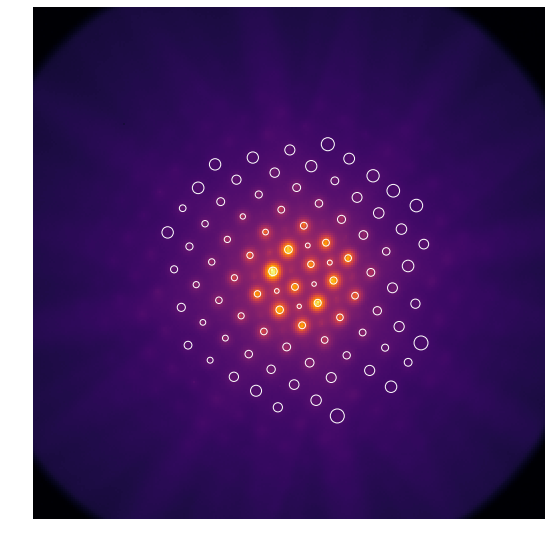

In [15]:
# Plot the image with circles indicating measured peak positions and widths
fig3, ax3 = aplt.arrayplot2d(limg0**0.3,2,'inferno') # plot image
# show points
lpost = np.transpose(lpkf)[0:3,0]
ax3.scatter(*lpost[0:2],s=16*lpost[2]**2, facecolors='none', edgecolors='w')

In [16]:
# Connect the peaks with a lattice (projected reciprocal lattice of the crystal)
# - Locate the peak closest to the image center.
#posc = 0.5 * ndim # ! Set the center position for the peak pattern !
posc = 0.5 * ndim - [0.,10.] # ! Set the center position for the peak pattern !
dmin = np.sqrt(np.dot(lpkf[0,0,0:2] - posc,lpkf[0,0,0:2] - posc))
imin = 0
for l in range(1, npkf):
    vd = lpkf[l,0,0:2] - posc
    dist = np.sqrt(np.dot(vd,vd))
    if dist < dmin:
        imin = l
        dmin = dist
icenter = imin
pcenter = lpkf[icenter,0,0:2]
print('- choosing center peak (ID, pos):', [icenter, [pcenter[0],pcenter[1]]])
# - Locate the next peak pointing along the horizontal axis ...
dmin = 1. * ndim[0]
imin = -1
for l in range(0, npkf):
    vd = lpkf[l,0,0:2] - pcenter
    dist = np.sqrt(np.dot(vd,vd))
    dpx = np.dot(vd,np.array([1.,0]))
    if dist < dmin and l != icenter and dpx > pkrad:
        imin = l
        dmin = dist
iplane0 = imin
pplane0 = lpkf[iplane0,0,0:2]
vplane0 = pplane0 - pcenter
print('- x-axis (ID, pos):', [iplane0, dmin, [vplane0[0],vplane0[1]]])
#    ... and one in the perpendicular direction
vpy = np.dot(np.array([[0.,-1],[1.,0.]]),vplane0 / np.sqrt(np.dot(vplane0,vplane0)))
dmin = 1. * ndim[0]
imin = -1
for l in range(0, npkf):
    vd = lpkf[l,0,0:2] - pcenter
    dist = np.sqrt(np.dot(vd,vd))
    dpy = np.dot(vd,vpy)
    if dist < dmin and l != icenter and dpy > 0.9*dist:
        imin = l
        dmin = dist
iplane1 = imin
pplane1 = lpkf[iplane1,0,0:2]
vplane1 = pplane1 - pcenter
print('- y-axis (ID, pos):', [iplane1, dmin, [vplane1[0],vplane1[1]]])

- choosing center peak (ID, pos): [40, [130.3827957973202, 115.45576363447876]]
- x-axis (ID, pos): [43, 9.670218972411838, [9.56379810616653, 1.4306993950090856]]
- y-axis (ID, pos): [54, 18.945473936412313, [-3.2794958007762034, 18.659471856619348]]


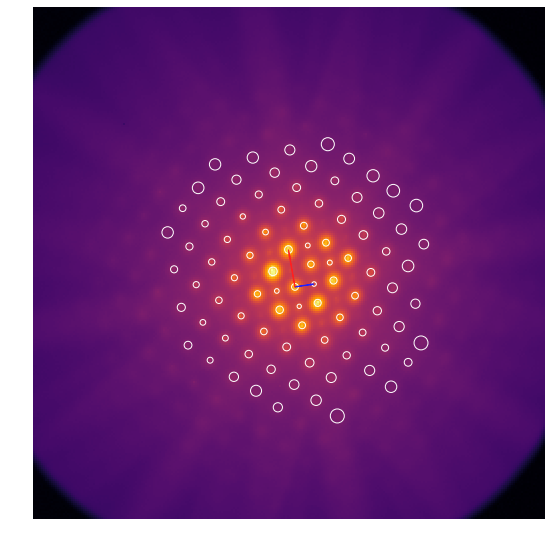

In [17]:
# Show the chosen basis by arrows in a plot
fig4, ax4 = aplt.arrayplot2d(limg0**0.2,2,'inferno') # plot image
# show points
lpost = np.transpose(lpkf)[0:3,0]
ax4.scatter(*lpost[0:2],s=16*lpost[2]**2, facecolors='none', edgecolors='w')
parr0 = Arrow(pcenter[0], pcenter[1], vplane0[0], vplane0[1], color='#2020ff')
ax4.add_patch(parr0)
parr1 = Arrow(pcenter[0], pcenter[1], vplane1[0], vplane1[1], color='#ff2020')
ax4.add_patch(parr1)

In [18]:
# Look at the plot and assign [hk] indices to the two arrows !
# This requires, that the two arrows are not parallel or anti-parallel.
hk0 = [1,0] # ! Set the [hk] for the BLUE ARROW pointing right !
hk1 = [0,2] # ! Set the [hk] for the RED ARROW pointing up !
# Set parameters determining the k-space scale, i.e. the projected Bragg spot vectors.
q10 = [2.563, 0.] # ! Set the reciprocal space vector corresponding to [10] in physical units !
q01 = [0., 2.563] # ! Set the reciprocal space vector corresponding to [01] in physical units !
# Set the center of the projection.
# This is a reference point, required for non-linear distortions.
p00 = [127.64, 125.63] # ! Set the position of the zero beam / probe-forming aperture center !
#
# translate the given pixel basis vectors to grid basis vectors
mhk = np.array([hk0,hk1])
mhki = np.linalg.inv(mhk)
pbase = np.array([vplane0,vplane1])
bhk = np.dot(mhki,pbase).T
bhki = np.linalg.inv(bhk)
#
# Predict peak positions from the parameters and keep those close to the measured peaks
lpkfhk = np.zeros((npkf,2), dtype=int)
lpkfpred = np.zeros((npkf,2), dtype=float)
for l in range(0, npkf): # loop over all peaks
    vpos = lpkf[l,0,0:2] - pcenter
    lpkfhk[l] = np.round(np.dot(bhki,vpos)).astype(int)
    lpkfpred[l] = np.dot(bhk,lpkfhk[l]) + pcenter

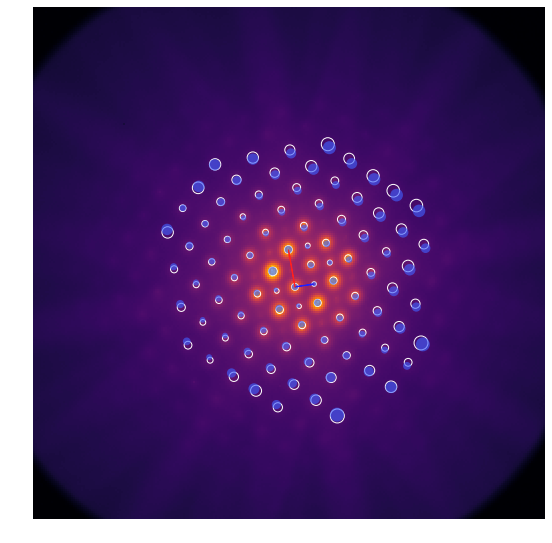

In [20]:
# Plot measured (white) vs. predicted (blue) peak positions.
# The prediction should reflect the measured pattern.
# In case of strong deviations, you may
# - choose a different center 'posc' above, thereby selecting
#   other initial basis vectors
# - reject small peaks in the center part by playing with
#   any of the rejection mechanisms applyied after cluster
#   recognition and peak fitting (population, width, etc.)
# - decrease the initial search range 'prange' and restart.
#
# !!! Warning !!!
#   It is very important here, that each prediction coincides
#   with one of the peaks. It must not fit perfectly, but there
#   should be no misses / gaps in the predicted pattern which
#   are not present in the peak pattern.
#     
fig5, ax5 = aplt.arrayplot2d(limg0**0.3,2,'inferno') # plot image
# show points
parr0 = Arrow(pcenter[0], pcenter[1], vplane0[0], vplane0[1], color='#2020ff')
ax5.add_patch(parr0)
parr1 = Arrow(pcenter[0], pcenter[1], vplane1[0], vplane1[1], color='#ff2020')
ax5.add_patch(parr1)
lpost = np.transpose(lpkf)[0:3,0]
ax5.scatter(*lpost[0:2],s=16*lpost[2]**2, facecolors='none', edgecolors='w')
ax5.scatter(*lpkfpred.T,s=16*lpost[2]**2, facecolors='#4060ffa0', edgecolors='none')

Fit results:
- k0 : [ 0.24292,-2.76133] +/- [ 0.07811, 0.07528]
- a10: [ 3.69395, 0.66488] +/- [ 0.03186, 0.03228]
- a01: [-0.67666, 3.69833] +/- [ 0.03076, 0.03099]
- rms resid. [pix]:   0.2869


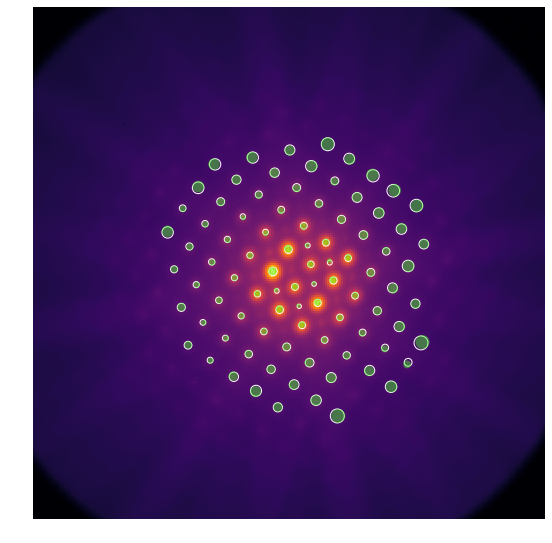

In [21]:
# Fit projection functions: k -> pixel to the set of peak positions
# using the lattice assignment made above.
# The fitting is done for pixel coordinates as functions of k in
# complex number notation.
#
# We want the outcome of the projection such that p(k'=0) = p00
# and therefore consider that the current k = 0 needs an offset k0,
# such that k' = k + k0. k0 will be fitted.
#
# - collect the k data and pixel data in complex number notation
kdata = np.zeros((npkf,2), dtype=float)
pdata = np.zeros((npkf,2), dtype=float)
m_k = np.array([q10,q01]) # physical lattice basis
m_ki = np.linalg.inv(m_k)
kdata = np.dot(m_k, lpkfhk.T).T # physical lattice vectors k
pdata = lpkf[:,0,0:2] - p00 # pixel lattice points, recentered to k=0
sdata = lpkf[:,1,0:2] # position errors
dp0 = pcenter - p00 # pixel shift between p(k=0) and test pattern
# - Set the maximum order of distorting aberrations (min. 1!)
ndist = 1
prj = proj2d(ndist) # init a 2d projection object
#prj = emilys.optics.projection.projection_func_2d(ndist)
m_kp1 = np.dot(bhk,m_ki) # this is an initial transformation from k -> pixel
v_k0 = np.dot(np.linalg.inv(m_kp1),dp0) # approximated shift of the k-pattern to k = 0
prjc0 = np.zeros(2*prj.num_terms, dtype=float) # init number of parameters
prjc0[2:6] = m_kp1.T.flatten()
luse = np.full(prj.num_terms, 1, dtype=int) # use flags
luse[0] = 0
#luse[6:10] = 0
# fit the projection parameters to match model to measurement
prjk0cf, prjccov, sqrdev = prj.fit_x0_lcoeff(kdata, pdata, ysigm=sdata, x0=v_k0, lcoeff0=prjc0, luse=luse)
prjcf = np.zeros(2*prj.num_terms, dtype=float)
prjcf[2:] = prjk0cf[2:] # pure projection result
v_k0f = prjk0cf[0:2] # k shift
lpkmpred = prj.project(kdata+v_k0f, prjcf, luse) + p00 # model predicted peak positions
# print a list of results
print('Fit results:')
print('- k0 : [{:8.5f},{:8.5f}] +/- [{:8.5f},{:8.5f}]'.format(*v_k0f,np.sqrt(prjccov[0,0]),np.sqrt(prjccov[1,1])))
for i in range(1, prj.num_terms):
    if luse[i] == 0: continue
    j = 2*i
    l, k = prj.get_lk(i)
    print('- a{:d}{:d}: [{:8.5f},{:8.5f}] +/- [{:8.5f},{:8.5f}]'.format(l,k,prjcf[j],prjcf[1+j],np.sqrt(prjccov[j,j]),np.sqrt(prjccov[1+j,1+j])))
print('- rms resid. [pix]: {:8.4f}'.format(np.sqrt(np.mean(sdata**2)*sqrdev/(2*(npkf-np.sum(luse)-1)))))
# plot fit
fig6, ax6 = aplt.arrayplot2d(limg0**0.3,2,'inferno') # plot image
# show points
lpost = np.transpose(lpkf)[0:3,0]
ax6.scatter(*lpost[0:2],s=16*lpost[2]**2, facecolors='none', edgecolors='w') # measured
ax6.scatter(*lpkmpred.T,s=16*lpost[2]**2, facecolors='#40ff2070', edgecolors='none') # model

In [ ]:
# projection function:
#
# Take care when interpreting the projection function.
# The meaning of each coefficient is specific to how the function is defined:
#
#    [p0,p1] = proj2d.project([q0,q1])
#            = sum_l,k [alk0,alk1] * binomial(l+k,l) * q0**l * q1**k
#
# where binomial(l+k,l) is a binomial factor
#
#    binomial(l+k,l) = (l+k)! / l! / k!
#
# You can may use proj2d.backproject([p0,p1]) for the inverse calculation.

In [ ]:
# %load_ext autoreload # load extension for the auto-reload magic
# %autoreload 1 # set the autoreload for module functions only for those imported with the %aimport magic
# %autoreload 2 # set the autoreload for all module functions, except for those excluded by the %aimport magic
# %aimport <module>